# Adaptive PDE discretizations on cartesian grids 
## Volume : Algorithmic tools
## Part : Non holonomic metrics and curvature penalization
## Chapter : Minimal path for a rolling ball

In this notebook, we present a numerical solution to the rolling ball problem: find the optimal way to roll a ball on a surface, so that it reaches a given position and orientation. The main properties of this problem are as follows:
* *High dimensional.* The configuration space of the system is 5 dimensional: three dimensions for the orientation of the ball, and two dimensions for its position on the surface. Arguably, 5 dimensions is (slightly past) the threshold where discretizations on uniform grids loose their relevance.
* *Strongly anisotropic* The problem is of sub-Riemannian type, and its anisotropy is fully generic, not aligned with the axes of the discretization grid.

The rolling ball problem admits numerous variants. One may for instance roll a ball along a one dimensional line, or on a more complex surface such as another ball.

We do not solve any PDE in this notebook, but merely introduce the models and present the results of geodesic shooting.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Description of the models](#1.-Description-of-the-models)
    * [1.1 Conversions](#1.1-Conversions)
    * [1.2 Action of a control on a state](#1.2-Action-of-a-control-on-a-state)
    * [1.3 Commutators](#1.3-Commutators)
    * [1.4 Ball models](#1.4-Ball-models)
    * [1.5 Ball with support](#1.5-Ball-with-support)
  * [2. Geodesic shooting](#2.-Geodesic-shooting)
    * [2.1 The Riemannian ball](#2.1-The-Riemannian-ball)
    * [2.2 The Reeds-Shepp ball](#2.2-The-Reeds-Shepp-ball)
    * [2.3 Riemannian ball on the plane](#2.3-Riemannian-ball-on-the-plane)
    * [2.4 Reeds-Shepp ball on the line](#2.4-Reeds-Shepp-ball-on-the-line)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('RollingBall_Models','Algo'))

In [2]:
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd import Metrics
from agd import FiniteDifferences as fd
norm = ad.Optimization.norm

In [3]:
import numpy as np; xp=np
import scipy.linalg
from scipy.integrate import odeint
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%5.3g" % x))

## 1. Description of the models

In [4]:
ball_state = np.array([1,2,3])/4 # Some arbitrary state
line_state  = np.concatenate((np.zeros(1),ball_state)) # Some arbitrary line-ball state
plane_state = np.concatenate((np.zeros(2),ball_state)) # Some arbitrary plane-ball state

### 1.1 Conversions

The state of a ball is perfectly described by a rotation matrix, mapping some reference position to the current position.
Following standard practice, we take advantage of the double cover of the rotation matrices by the quaternionic unit ball. 
The quaternionic unit ball, which is embedded in four-dimensional space, is itself parametrized from its three dimensional equatorial hyperplane. Additional detail is presented below.

**Rotations and unit quaternions**

We provide the mathematical context for completeness, but eventually the formulas $q\mapsto R_q$ parametrizing rotations from unit quaternions are used as black boxes, with the caveat that $R_q = R_{-q}$.

Let $H$ be the four-dimensional non-commutative field of quaternions. 
Introduce the unit sphere $S_4$
$$
    S_4 = \{\alpha + \beta i + \gamma j + \delta k;\ \alpha^2+\beta^2+\gamma^2+\delta^2=1\}
$$
and the imaginary unit sphre $S_3$ defined as follows 
$$
    S_3 = \{\beta i + \gamma j + \delta k;\ \beta^2+\gamma^2+\delta^2=1\} = \{q \in S_4;\ \mathrm{Re}(q)=0\}.
$$

It is known that any $q \in S_4$ induces a rotation on $S_3$, by conjugacy:
$$
    R_q : z \in S_3 \mapsto q z q^{-1},
$$
and that $q \in S_4 \mapsto R_q \in \mathrm{SO}_3$ is a double cover, with $R_q = R_{-q}$ for all $q \in S_4$.

In [5]:
def rotation_from_quaternion(q):
    """Produces the rotation associated with a unit quaternion."""
    qr,qi,qj,qk = q
    identity = fd.as_field(xp.eye(3),qr.shape,depth=2)
    return identity + 2*ad.array([
        [-(qj**2+qk**2), qi*qj-qk*qr, qi*qk+qj*qr],
        [qi*qj+qk*qr, -(qi**2+qk**2), qj*qk-qi*qr],
        [qi*qk-qj*qr, qj*qk+qi*qr, -(qi**2+qj**2)]])

def quaternion_from_rotation(r):
    """Produces the unit quaternion, with positive real part, associated with a rotation."""
    qr = np.sqrt(lp.trace(r)+1.)/2.
    qi = (r[2,1]-r[1,2])/(4*qr)
    qj = (r[0,2]-r[2,0])/(4*qr)
    qk = (r[1,0]-r[0,1])/(4*qr)
    return ad.array([qr,qi,qj,qk])

**Euclidean space and quaternions**

Let $S_d\subset R^{d+1}$ be the $d$-dimensional unit sphere. Then to any point $(0,e) \in R \times R^d$ of the equatorial plane we can associate a point of the sphere:
$$
    \frac {(1-\|e\|^2,2 e)}{1+\|e\|^2}.
$$
This mapping is onto the sphere, except for the south pole. It is implemented in the next cell, as well as the reciproqual.

In [6]:
def quaternion_from_euclidean(e):
    """Produces a point in the unit sphere by projecting a point in the equator plane."""
    e = ad.asarray(e)
    e2 = lp.dot_VV(e,e)
    return ad.array([1.-e2,*(2*e)])/(1.+e2)
def euclidean_from_quaternion(q):
    """Produces a point in the equator plane from a point in the unit sphere."""
    e2 = (1-q[0])/(1+q[0])
    return q[1:]*((1+e2)/2.)

By composition, we can parametrize quaternions from euclidean space and conversely.

In [7]:
def euclidean_from_rotation(r,qRef):
    """Produces an euclidean point from a rotation, 
    selecting in the intermediate step the quaternion 
    in the same hemisphere as qRef"""
    q = quaternion_from_rotation(r)
    q[:,lp.dot_VV(q,qRef)<0] *= -1
    return euclidean_from_quaternion(q)

def rotation_from_euclidean(e): 
    """Produces a rotation from an euclidean point. 
    Also returns the intermediate quaternion."""
    q = quaternion_from_euclidean(e)
    return rotation_from_quaternion(q),q

In [8]:
def check(e):
    r,q = rotation_from_euclidean(e)
    assert np.allclose( norm(q,axis=0), 1.)
    assert np.allclose(lp.dot_AA(lp.transpose(r),r),np.eye(3))
    assert np.allclose(e,euclidean_from_rotation(r,q))

In [9]:
check(ball_state) # One test for each hemisphere
check(2*ball_state) 

**Antisymmetric matrices and their exponentials**

In [10]:
def antisym(a,b,c):
    z=np.zeros_like(a)
    return ad.array([[z, -c, b], [c, z, -a], [-b, a, z]])

def exp_antisym(a,b,c):
    """Matrix exponential of antisym(a,b,c).
    Note : (a,b,c) is the axis of rotation."""
    s = ad.asarray(a**2+b**2+c**2)
    s[s==0]=1e-20 # Same trick as in numpy's sinc function ...
    sq = np.sqrt(s)
    co,si = np.cos(sq),np.sin(sq)
    cosc,sinc = (1-co)/s,si/sq    
    return ad.array([
        [co+cosc*a**2, cosc*a*b-sinc*c, cosc*a*c+sinc*b],
        [cosc*a*b+sinc*c, co+cosc*b**2, cosc*b*c-sinc*a],
        [cosc*a*c-sinc*b, cosc*b*c+sinc*a, co+cosc*c**2]])

In [11]:
assert np.allclose(exp_antisym(1,2,3),scipy.linalg.expm(antisym(1,2,3)))

### 1.2 Action of a control on a state

In this notebook, controls are antisymmetric matrices described by their coordinates in $R^3$. They act additively on the physical state, and multiplicatively (through their exponential) on the angular state. 

The action of a constant control during unit time is explicit, hence does not need to be numerically integrated. In order to recover the flow, one may simply apply an infinitesimal control during a unit time. The flow may also be obtained directly, see the end of this subsection.

In [12]:
def advance(state,control):
    """Move from a state to another by applying a control during a unit time"""
    state,control = map(ad.asarray,(state,control))
    state_physical = state[:-3]
    state_physical = state_physical + 0.25*control[:len(state_physical)] # Additive action on the physical state
    
    state_angular,qRef = rotation_from_euclidean(state[-3:])
    state_angular = lp.dot_AA(state_angular,exp_antisym(*control)) # Left invariant action
    
    return np.concatenate([state_physical,euclidean_from_rotation(state_angular,qRef)],axis=0)

Close to the origin, the three controls act independently on each coordinate of the euclidean parametrization of the sphere.

In [13]:
δ = ad.Dense.identity(constant=0.)
advance([0,0,0],[δ,0,0])

denseAD(array([    0,     0,     0]),
array([[ 0.25],
       [    0],
       [    0]]))

In [14]:
advance([0,0,0],[0,δ,0])

denseAD(array([    0,     0,     0]),
array([[    0],
       [ 0.25],
       [    0]]))

In [15]:
advance([0,0,0],[0,0,δ])

denseAD(array([    0,     0,     0]),
array([[    0],
       [    0],
       [ 0.25]]))

They also act on the plane or line parametrization, if present.

In [16]:
advance([0,0,0,0,0],[δ,0,0])

denseAD(array([    0,     0,     0,     0,     0]),
array([[ 0.25],
       [    0],
       [ 0.25],
       [    0],
       [    0]]))

In [17]:
advance([0,0,0,0,0],[0,δ,0])

denseAD(array([    0,     0,     0,     0,     0]),
array([[    0],
       [ 0.25],
       [    0],
       [ 0.25],
       [    0]]))

More complex motions, known as commutators, are needed to control the sphere and the plane independently, or to control the sphere using only two of the three available controls. 

Before turning to these more complex motions, we provide, as promised, the direct flow expression.

In [18]:
def flow(state,control):
    """Flow vector for a given state and control"""
    state,control = map(ad.asarray,(state,control))
    state_physical = state[:-3]
    flow_physical = 0.25*control[:len(state_physical)] # Additive action on the physical state
    
    state_angular,qRef = rotation_from_euclidean(state[-3:])
    flow_angular = lp.dot_AA(state_angular,antisym(*control)) # Left invariant action

    ϵ = ad.Dense.identity(constant=0.)    
    rec_ad = ad.is_ad(state_angular) or ad.is_ad(flow_angular) # Recursve AD requires a little bit of care
    if rec_ad: state_angular,flow_angular = map(ad.disassociate,(state_angular,flow_angular))
    flow_angular_eucl = euclidean_from_rotation(state_angular+ϵ*flow_angular,qRef).gradient(0) # Differentiate the reverse mapping
    if rec_ad: state_angular,flow_angular = map(ad.associate,(state_angular,flow_angular))
    
    return np.concatenate([flow_physical,flow_angular_eucl],axis=0)

In [19]:
assert np.allclose(advance(plane_state,δ*ad.array([1,2,3])).gradient(0),flow(plane_state,[1,2,3]))

### 1.3 Commutators

In [20]:
def commute(state,control1,control2):
    state,control1,control2 = map(ad.asarray,(state,control1,control2))
    state = advance(state, control1)
    state = advance(state, control2)
    state = advance(state,-control1)
    state = advance(state,-control2)
    return state 

On the sphere, the commutator of the first two controls is the third control. This allows to bring the sphere from any state to any other state using only two controls, albeit rather inefficiently since the motion along the third control generated by a commutator is of second order.

In [21]:
δ = ad.Dense2.identity(constant=0.)
commute([0,0,0],[δ,0,0],[0,δ,0]) # Motion generated by a commutator of the first two controls

denseAD2(array([    0,     0,     0]),
array([[    0],
       [    0],
       [    0]]),
array([[[    0]],

       [[    0]],

       [[  0.5]]]))

In [22]:
advance([0,0,0],[0,0,δ**2]) # Same motion generated by the third control, at second order.

denseAD2(array([    0,     0,     0]),
array([[    0],
       [    0],
       [    0]]),
array([[[    0]],

       [[    0]],

       [[  0.5]]]))

Likewise, on the sphere, the commutator of the second and third control is minus the first one.

In [23]:
commute([0,0,0],[0,δ,0],[0,0,δ]) # Motion generated by a commutator of the second and third controls

denseAD2(array([    0,     0,     0]),
array([[    0],
       [    0],
       [    0]]),
array([[[  0.5]],

       [[    0]],

       [[    0]]]))

However, on the plane, which is a vector space, all controls commute. This observation allows to control the motion of the sphere without changing its position on the plane.

In [24]:
commute([0,0,0,0,0],[0,δ,0],[0,0,δ]) # Motion generated by a commutator of the second and third controls.
# Only the sphere is affected

denseAD2(array([    0,     0,     0,     0,     0]),
array([[    0],
       [    0],
       [    0],
       [    0],
       [    0]]),
array([[[    0]],

       [[    0]],

       [[  0.5]],

       [[    0]],

       [[    0]]]))

In [25]:
advance([0,0,0,0,0],[δ**2,0,0]) # Motion generated by the first control, at second order. 
# Both the sphere and plane are affected

denseAD2(array([    0,     0,     0,     0,     0]),
array([[    0],
       [    0],
       [    0],
       [    0],
       [    0]]),
array([[[  0.5]],

       [[    0]],

       [[  0.5]],

       [[    0]],

       [[    0]]]))

The rank of a sub-Riemannian model is the depth of the control commutators needed to generate the entire tangent space.
A rank-0 model is amounts to Riemannian manifold. The numerical simulation, using PDE techniques, of models of rank larger than or equal to two is novel to the knowledge of the author.

### 1.4 Ball models

We present the hamiltonians of the different models, in the form of the symmetric semi-definite matrix defining the dual metric, which makes sense since the models are sub-Riemannian. 

<!---
A more classical presentation, involving the position and impulsion variables, is presented in next section.
--->

In [26]:
def make_hamiltonian(controls,advance=advance):
    """Produces the hamiltonian function associated to a sub-Riemannian model, 
    defined by its controls and the advance function"""
    def hamiltonian(state):
        """The hamiltonian, a quadratic form on the co-tangent space"""
        # Array formatting to apply to several states simultanously
        state=ad.asarray(state); controls_ = fd.as_field(controls,state.shape[1:],depth=1) 
        
        grad = advance(state,controls_).gradient()
        return lp.dot_AA(lp.transpose(grad),grad)
    return hamiltonian

In [27]:
δ = 4*ad.Dense.identity(constant=[0.,0.,0.]) # Three independent symbolic perturbations

The **Riemannian ball** is governed by the three controls, with the same strength on each axis, and its state space is the ball alone. It is thus a Riemannian model. At the origin, the Hamiltonian is the identity matrix.

In [28]:
H_Riemann = make_hamiltonian(δ)
H_Riemann([0,0,0])

array([[    1,     0,     0],
       [    0,     1,     0],
       [    0,     0,     1]])

At any point in space, this hamiltonian is a positive definite matrix, whose inverse is the Riemannian metric. Because of our choice of coordinates, this metric is *conformal*, in other words proportional to the euclidean metric (up to machine precision).

In [29]:
H_Riemann(ball_state)

array([[ 3.52, 5.79e-13, 8.6e-13],
       [5.79e-13,  3.52, 1.73e-12],
       [8.6e-13, 1.73e-12,  3.52]])

The **Reeds shepp ball** is governed only two of the three controls, missing the middle one, and is a sub-Riemannian model of rank one. This model can also be regarded as describing a wheelchair-like vehicle moving on a ball.

In [30]:
δRS = [δ[0],0,δ[2]] # The y-axis rotation control is lacking
H_ReedsShepp = make_hamiltonian(δRS) 
H_ReedsShepp([0,0,0])

array([[    1,     0,     0],
       [    0,     0,     0],
       [    0,     0,     1]])

At any point in space, this hamiltonian is a positive semi-definite matrix, with two non-zero eigenvalues.

In [31]:
ham = H_ReedsShepp(ball_state)
ham, np.linalg.eigvalsh(ham)

(array([[ 1.95, 0.781,  1.56],
        [0.781,  3.13, -0.781],
        [ 1.56, -0.781,  1.95]]),
 array([2.64e-16,  3.52,  3.52]))

The **torqueless ball** is governed by two of the three controls, missing the last one. On the ball alone, this model is isomorphic to the Reeds-Shepp model. However the situation changes when put on a plane, as discussed below.

In [32]:
δTL = [δ[0],δ[1],0] # The z-axis rotation control is lacking
H_Torqueless = make_hamiltonian(δTL)
H_Torqueless([0,0,0])

array([[    1,     0,     0],
       [    0,     1,     0],
       [    0,     0,     0]])

In [33]:
ham = H_Torqueless(ball_state)
ham, np.linalg.eigvalsh(ham)

(array([[ 1.62, -0.344, -1.72],
        [-0.344,  3.45, -0.312],
        [-1.72, -0.312,  1.95]]),
 array([-1.11e-16,  3.52,  3.52]))

### 1.5 Ball with support

The same *hamiltonian* functions can be reused, since the advance function handles the supports as well.

The **Riemannian ball on a plane** is a rank one sub-Riemannian model. The ball may be rolled along both the $x$-axis and $y$-axis, and its rotation around the $z$-axis is also controlled.

The hamiltonian is degenerate, as expected, with two vanishing eigenvalues due to the fact that motion in the plane is tied to the rotation of the ball.

In [34]:
ham = H_Riemann(np.zeros(5))
ham,np.linalg.eigvalsh(ham)

(array([[    1,     0,     1,     0,     0],
        [    0,     1,     0,     1,     0],
        [    1,     0,     1,     0,     0],
        [    0,     1,     0,     1,     0],
        [    0,     0,     0,     0,     1]]),
 array([    0,     0,     1,     2,     2]))

The situation is the same at any point in space.

In [35]:
ham = H_Riemann(plane_state)
ham,np.linalg.eigvalsh(ham)

(array([[    1,     0,  0.25,  1.75, -0.625],
        [    0,     1, -1.25, 0.625,  1.25],
        [ 0.25, -1.25,  3.52, 5.79e-13, 8.6e-13],
        [ 1.75, 0.625, 5.79e-13,  3.52, 1.73e-12],
        [-0.625,  1.25, 8.6e-13, 1.73e-12,  3.52]]),
 array([-8e-17, 7.45e-17,  3.52,  4.52,  4.52]))

The **Reeds-Shepp ball on a line** is a rank two sub-Riemannian model. The ball may only be rolled along the $x$-axis, and rotated around the $z$-axis.
In order to generate a rotation around the $y$-axis, a commutator of these two motions is required. In order to generate a rotation around the $x$-axis, without any motion in the plane, a second order commutator is needed involving rotation around the $y$-axis and a rotation around the $z$-axis.

In [36]:
ham = H_ReedsShepp(np.zeros(4))
ham,np.linalg.eigvalsh(ham)

(array([[    1,     1,     0,     0],
        [    1,     1,     0,     0],
        [    0,     0,     0,     0],
        [    0,     0,     0,     1]]),
 array([    0,     0,     1,     2]))

In [37]:
ham = H_ReedsShepp(line_state)
ham,np.linalg.eigvalsh(ham)

(array([[    1,  0.25,  1.75, -0.625],
        [ 0.25,  1.95, 0.781,  1.56],
        [ 1.75, 0.781,  3.13, -0.781],
        [-0.625,  1.56, -0.781,  1.95]]),
 array([-3.37e-16, 4.61e-16,  3.52,  4.52]))

The **torqueless ball on a plane** is a rank two sub-Riemannian model. The ball may be rolled along the $x$-axis and the $y$-axis, but not rotated around the $z$-axis (think of a punctual control, without any torque). In order to generate a rotation around the $z$-axis, a commutator of the rolling motions along the $x$-axis and the $y$-axis is needed. In order to generate a pure rotation around the $x$-axis or the $y$-axis, one needs a commutator of the pure rotation around the $z$-axis, and of the rolling motion along the $x$ or the $y$ axis.

In [38]:
ham = H_Torqueless(np.zeros(5))
ham,np.linalg.eigvalsh(ham)

(array([[    1,     0,     1,     0,     0],
        [    0,     1,     0,     1,     0],
        [    1,     0,     1,     0,     0],
        [    0,     1,     0,     1,     0],
        [    0,     0,     0,     0,     0]]),
 array([    0,     0,     0,     2,     2]))

In [39]:
ham = H_Torqueless(plane_state)
ham,np.linalg.eigvalsh(ham)

(array([[    1,     0,  0.25,  1.75, -0.625],
        [    0,     1, -1.25, 0.625,  1.25],
        [ 0.25, -1.25,  1.62, -0.344, -1.72],
        [ 1.75, 0.625, -0.344,  3.45, -0.312],
        [-0.625,  1.25, -1.72, -0.312,  1.95]]),
 array([-3.67e-16, 7.34e-17, 5.62e-16,  4.52,  4.52]))

## 2. Geodesic shooting

We compute, for checking their consistency, some geodesics of the considered models model. They correspond to the free motion of the corresponding physical system, without external force or obstacles.

**Note on performance.** Geodesic shooting is expected to be a cheap operation numerically. However computation times are here not negligible, due to  the overhead of Python and to the heavy and recursive use of automatic differentiation.

**Conflict of notations.** Here and below, the state and impulsion for a hamiltonian system are denoted $q,p$, as is classical. In our setting, the state belongs to Euclidean space, and the letter $q$ does *not* refer to quaternion.

In [40]:
# Some arbitrary initial impulsions
ball_impulsion = np.array([4,5,6])/3
#plane_impulsion = np.concatenate([np.array([2,3])/2,ball_impulsion],axis=0)
line_impulsion = np.concatenate([[0.5],ball_impulsion],axis=0)

We wrap our hamiltonians within the `Metrics.Hamiltonian` class, which provides a few helper utilities for differentiating hamiltonians and integrating the resulting flow.

In [41]:
from agd.ODE.hamiltonian import GenericHamiltonian

In [42]:
def class_hamiltonian(H):
    def H_(q,p): return 0.5*lp.dot_VAV(p,H(q),p) # (Sub-)Riemannian hamiltonian, the kinetic energy
    return GenericHamiltonian(H_,disassociate_ad=True) # Disassociate needed for recursive AD

In [43]:
h_Riemann,h_ReedsShepp,h_Torqueless = map(class_hamiltonian,(H_Riemann,H_ReedsShepp,H_Torqueless))

In [44]:
h_Riemann.flow(ball_state,ball_impulsion) # The symplectic flow DpH,-DqH

(array([ 4.69,  5.86,  7.03]), array([-8.02,   -16, -24.1]))

For applications, or only the sake of curiosity, one may want to recover the optimal controls associated with a given position and impulsion.

In [45]:
def optimal_control(controls,advance=advance):
    """
    Produces a function for obtaining the optimal control 
    associated with a given state and impulsion.
    - controls : the available controls, described as independent AD 
        perturbations, whose sum of squares should be bounded.
    """
    def get_optimal_control(state,impulsion):
        # Array formatting to apply to several states simultanously
        state=ad.asarray(state); controls_ = fd.as_field(controls,state.shape[1:],depth=1) 
        
        grad = advance(state,controls_).gradient()
        return lp.dot_AV(grad,impulsion)
    return get_optimal_control

In [46]:
c_Riemann,c_ReedsShepp,c_Torqueless = map(optimal_control,(δ,δRS,δTL))

Finally, we need the following function displays a sphere, to be used as a background for our trajectories.

In [47]:
def plot_sphere(ax):
    stride = 3
    u = np.linspace(0, 2 * np.pi, 13*stride)
    v = np.linspace(0, np.pi, 7*stride)

    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    
    ax.plot_wireframe(x, y, z, rstride=stride, cstride=stride, color='gray',alpha=0.5)

### 2.1 The Riemannian ball

The ball is spinning without friction, at constant speed, on a fixed axis.

In [48]:
%%time
q,p,T = h_Riemann.integrate(ball_state,ball_impulsion,scheme='Runge-Kutta-4',T=1.,niter=150,path=True)

CPU times: user 13.3 s, sys: 43.1 ms, total: 13.3 s
Wall time: 13.3 s


The euclidean parametrization of the sphere configuration is not very telling, but we do observe a periodic motion, as expected.

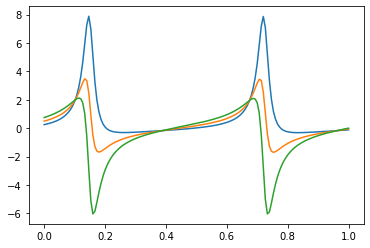

In [49]:
plt.plot(T,q[0], T,q[1], T,q[2]);

The hamiltonian is an invariant of motion. Since we use a non-symplectic scheme, and since the solved ODE is a bit stiff , the numerical conservation is only approximate. Stiffness is because the tracked point goes close to the pole (-1,0,0,0) of the quaternion sphere, where the parametrization is singular.

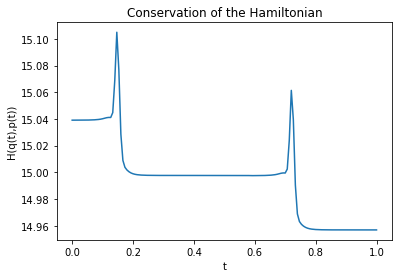

In [50]:
plt.title("Conservation of the Hamiltonian")
plt.xlabel("t"); plt.ylabel("H(q(t),p(t))")
plt.plot(T,h_Riemann.H(q,p));

The rotation axis, and angular velocity, are directly related to the control. 

In [51]:
c = c_Riemann(q,p)
axis = c[:,0]
print(f"Initial axis of rotation {axis/norm(axis)}, angular velocity {2*norm(axis)}, period {np.pi/norm(axis)}")

Initial axis of rotation [0.365 0.342 0.866], angular velocity 10.968705484246339, period 0.5728283356868074


The optimal controls are ... constant in time. This is expected behavior: the ball is spinning at constant speed on a fixed axis. 

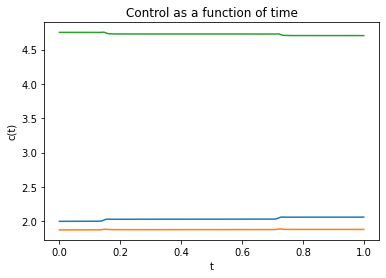

In [52]:
plt.title("Control as a function of time")
plt.xlabel("t"); plt.ylabel("c(t)")
plt.plot(T,c[0], T,c[1], T,c[2]);

Finally, we display the trajectories of some points of the sphere, as time evolves.

In [53]:
r,_ = rotation_from_euclidean(q) # Note : the state q is an Euclidean vector, not a quaternion.

/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


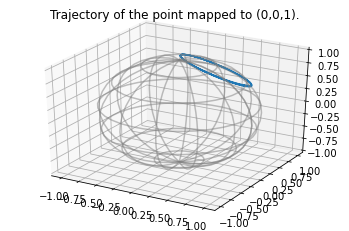

In [54]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
plt.title("Trajectory of the point mapped to (0,0,1).")
plot_sphere(ax)
plt.plot(*r[:,-1]);

/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


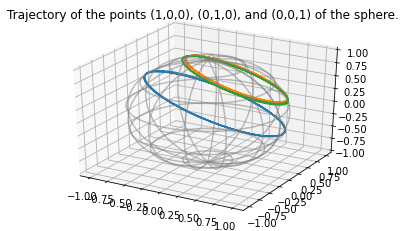

In [55]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
plt.title("Trajectory of the points (1,0,0), (0,1,0), and (0,0,1) of the sphere.")
plot_sphere(ax)
plt.plot(*r[0,:]); plt.plot(*r[1,:]); plt.plot(*r[2,:]);

### 2.2 The Reeds-Shepp ball

The Reeds-Shepp ball is spun freely, except for the constraint that it can never roll around the $y$-axis.

In [56]:
%%time
q,p,T = h_ReedsShepp.integrate(ball_state,ball_impulsion,scheme='Runge-Kutta-4',T=1.5,niter=150,path=True)

CPU times: user 13.4 s, sys: 41.3 ms, total: 13.5 s
Wall time: 13.5 s


The motion of the Reeds-Shepp ball is not periodic: it has no reason to be.

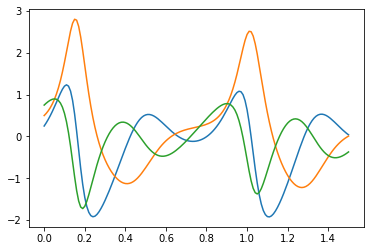

In [57]:
plt.plot(T,q[0], T,q[1], T,q[2]);

The Hamiltonian is conserved with rather good accuracy, despite the fact that the scheme is not symplectic.

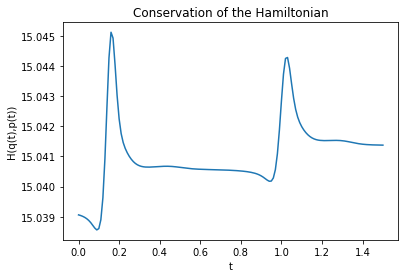

In [58]:
plt.title("Conservation of the Hamiltonian")
plt.xlabel("t"); plt.ylabel("H(q(t),p(t))")
plt.plot(T,h_Riemann.H(q,p));

The instantaneous rotation axis varies, with one constant property : the y component vanishes.

In [59]:
c = c_ReedsShepp(q,p)
axis = c[:,0]
print(f"Initial axis of rotation {axis/norm(axis)}, angular velocity {2*norm(axis)}, period {np.pi/norm(axis)}")

Initial axis of rotation [0.388     0 0.922], angular velocity 10.307764064049517, period 0.6095585102780446


The instantaneous axis of rotation appears to be periodic (TODO : check). Yet this does not imply a periodic motion of the sphere, which is a *non-commutative* (matrix product of rotations) primitive of these controls.

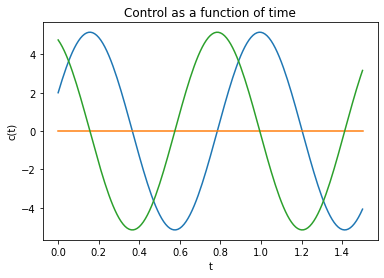

In [60]:
plt.title("Control as a function of time")
plt.xlabel("t"); plt.ylabel("c(t)")
plt.plot(T,c[0], T,c[1], T,c[2]);

In [61]:
r,_ = rotation_from_euclidean(q) 

/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


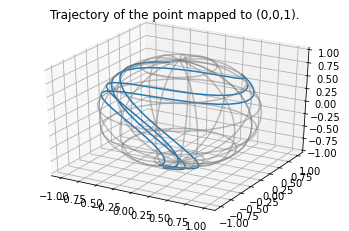

In [62]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
plt.title("Trajectory of the point mapped to (0,0,1).")
plot_sphere(ax)
plt.plot(*r[:,2]);

The considered model, and the above trajectory is equivalent to the motion of a Reeds-Shepp vehicle (wheel-chair like) on the sphere.
A distinctive property of such models is the presence of cusps in the trajectory, which correspond to pure rotations around the $z$-axis. They are more easily viewed on a planar projection.

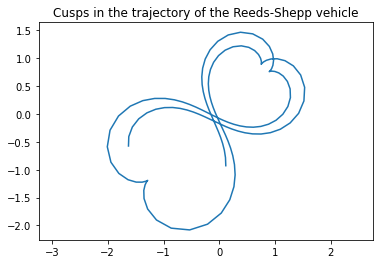

In [63]:
sphere_projection = euclidean_from_quaternion # The code is actually dimension independent
plt.title("Cusps in the trajectory of the Reeds-Shepp vehicle")
plt.plot(*sphere_projection(-r[:,-1])); plt.axis('equal');

Note that modifying the amount of curvature penalization is easy: one only has to balance differently the cost of the rotation around the $x$-axis and around the $z$-axis in the control parameters.

In [64]:
δRS # Same control strength around the x and z axes.

[denseAD(array(    0),array([    4,     0,     0])),
 0,
 denseAD(array(    0),array([    0,     0,     4]))]

### 2.3 Riemannian ball on the plane

In [65]:
h_Riemann.shape_free = None # Changing the state dimension

In [66]:
plane_impulsion = np.concatenate([-np.array([3,2])/2,ball_impulsion],axis=0)

In [67]:
%%time
q,p,T = h_Riemann.integrate(plane_state,plane_impulsion,scheme='Runge-Kutta-4',T=2.,niter=250,path=True)

CPU times: user 24.8 s, sys: 75.9 ms, total: 24.8 s
Wall time: 24.9 s


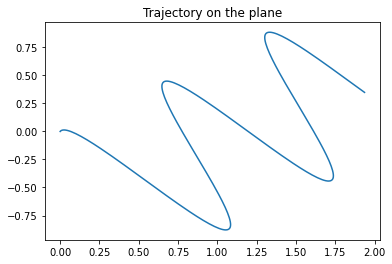

In [68]:
plt.title("Trajectory on the plane")
plt.plot(q[0],q[1]);

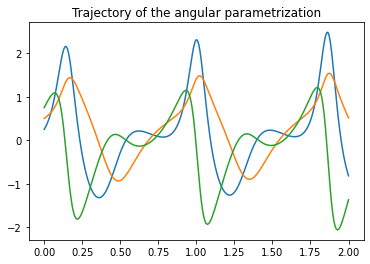

In [69]:
plt.title("Trajectory of the angular parametrization")
plt.plot(T,q[2], T,q[3], T,q[4]);

The Hamiltonian is conserved, as it should be. The optimal controls appear to be periodic, yet the trajectory of the ball is not, neither in angular space nor in physical space.

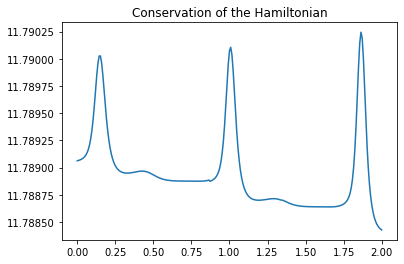

In [70]:
plt.title("Conservation of the Hamiltonian")
plt.plot(T,h_Riemann.H(q,p));

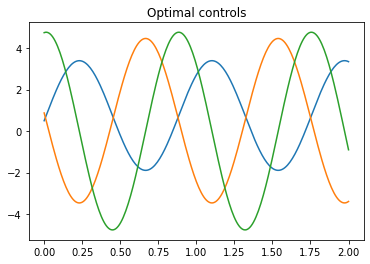

In [71]:
plt.title("Optimal controls")
c=c_Riemann(q,p)
plt.plot(T,c[0],T,c[1],T,c[2]);

In [72]:
r,_ = rotation_from_euclidean(q[-3:]) 

/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


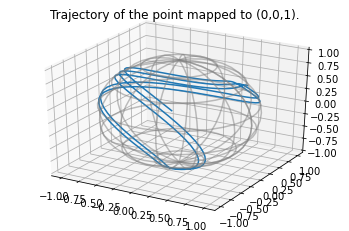

In [73]:
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
plt.title("Trajectory of the point mapped to (0,0,1).")
plot_sphere(ax)
plt.plot(*r[:,-1]);

We do not really see cusps here.

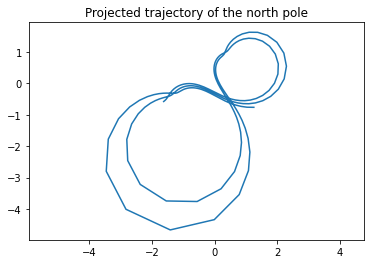

In [74]:
plt.title("Projected trajectory of the north pole")
plt.plot(*sphere_projection(-r[:,-1])); plt.axis('equal');

### 2.4 Reeds-Shepp ball on the line

In [75]:
h_ReedsShepp.shape_free = None # Changing the state dimension

In [76]:
%%time
q,p,T = h_ReedsShepp.integrate(line_state,line_impulsion,scheme='Runge-Kutta-4',T=2.,niter=250,path=True)

CPU times: user 23.6 s, sys: 70.3 ms, total: 23.6 s
Wall time: 23.7 s


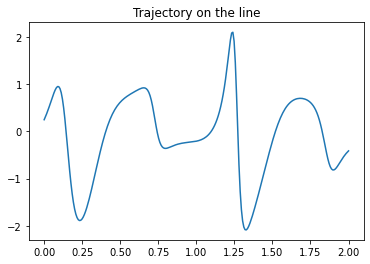

In [77]:
plt.title("Trajectory on the line")
plt.plot(T,q[1]);

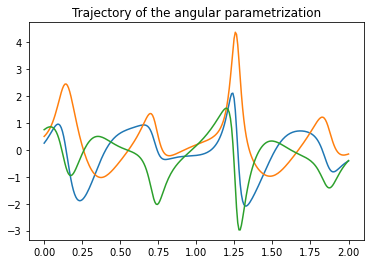

In [78]:
plt.title("Trajectory of the angular parametrization")
plt.plot(T,q[1], T,q[2], T,q[3]);

The Hamiltonian is well conserved, and the optimal controls are periodic.

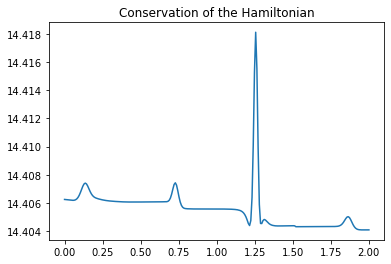

In [79]:
plt.title("Conservation of the Hamiltonian")
plt.plot(T,h_ReedsShepp.H(q,p));

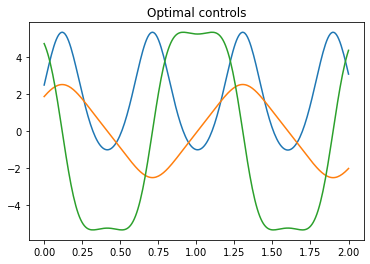

In [80]:
plt.title("Optimal controls")
c=c_Riemann(q,p)
plt.plot(T,c[0],T,c[1],T,c[2]);